<a href="https://colab.research.google.com/github/mendyhsu/Capstone2/blob/main/TF2_CNN_FashionProducts_30_GrayScale_BatchNorm_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN classifier on Fashion Products (grayscale images)

* y [target] - **Product categories**: 
the product classes come with three hierarchies, `masterCategory`, `subCategory`, and `articleType`. We will refine the product classes by considering three of them.

* X [input] - **Images**: 
each has size of 80 (height), 60 (width), 1 (Grayscale).

In [1]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-beta1

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.6.0


In [2]:
# Additional imports
import glob
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization #GlobalMaxPooling2D
from tensorflow.keras.models import Model, Sequential

## Load Files

In [3]:
# Access files from your Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!ls 'gdrive/MyDrive/Tensorflow 2.0 Deep Learning and AI/'

'archive (1).zip'		   'TF2.0 ANN Fashion MNIST.ipynb'
 machine_learning_examples-master  'TF2.0 ANN MNIST.ipynb'
 model_best_color.h5		   'TF2.0 CNN Fashion MNIST.ipynb'
 styles_cleaned.csv		   'TF2.0 Linear Classification_Diabetes.ipynb'
'TF2.0 ANN Ecoli.ipynb'		    valid_test_img.pickle


In [5]:
from zipfile import ZipFile

with ZipFile('gdrive/MyDrive/Tensorflow 2.0 Deep Learning and AI/archive (1).zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [6]:
!ls 

gdrive	images	myntradataset  sample_data  styles.csv


In [7]:
## List of image file paths
img_files = glob.glob('myntradataset/images/*.jpg')

#img_id = [int(re.findall(r'\d+', img)[0]) for img in img_files]
img_id = [(re.findall(r'\d+', img)[0]) for img in img_files]

print('Total number of images:', len(set(img_id)))


Total number of images: 44441


myntradataset/images/54967.jpg
(80, 60, 3)


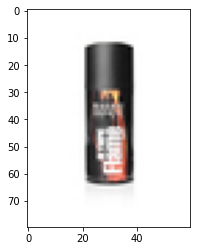

In [8]:
## View the image
image_path = 'myntradataset/images/54967.jpg'#img_files[20]
print(image_path)
image = tf.keras.preprocessing.image.load_img(image_path)
input_arr = tf.keras.preprocessing.image.img_to_array(image)
_ = plt.imshow(input_arr/255)
inputShape = input_arr.shape
print(inputShape)

In [9]:
## Check styles_cleaned.csv
!head 'gdrive/MyDrive/Tensorflow 2.0 Deep Learning and AI/styles_cleaned.csv'

id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,Class
15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,Shirts
39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,Bottomwear
59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,Watches
21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,Bottomwear
53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,Tshirts
1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011,Casual,Inkfruit Mens Chain Reaction T-shirt,Tshirts
30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012,Ethnic,Fabindia Men Striped Green Shirt,Shirts
26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012,Casual,Jealous 21 Women Purple Shirt,Shirts
29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012,Casual,Puma Men Pack of 3 Sock

In [10]:
## Load styles sheets
styles = pd.read_csv('gdrive/MyDrive/Tensorflow 2.0 Deep Learning and AI/styles_cleaned.csv', header=None, names=range(11))
#styles.drop(columns=10, inplace=True)
styles.columns = styles.iloc[0]
styles = styles.iloc[1:].reset_index(drop=True)
#styles.id = pd.to_numeric(styles['id'])
#styles.year = pd.to_numeric(styles['year'])
styles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44440 entries, 0 to 44439
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  44440 non-null  object
 1   gender              44440 non-null  object
 2   masterCategory      44440 non-null  object
 3   subCategory         44440 non-null  object
 4   articleType         44440 non-null  object
 5   baseColour          44425 non-null  object
 6   season              44419 non-null  object
 7   year                44439 non-null  object
 8   usage               44123 non-null  object
 9   productDisplayName  44433 non-null  object
 10  Class               44440 non-null  object
dtypes: object(11)
memory usage: 3.7+ MB


In [11]:
print('Total number of id (styles):', len(set(styles.id)))
print('Total number of images:', len(set(img_id)))

## Keep the overlaped images==id
no_img = set(styles.id).difference(img_id)
styles = styles[~styles.id.isin(no_img)]
styles.shape

Total number of id (styles): 44440
Total number of images: 44441


(44440, 11)

In [12]:
styles.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,Class
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,Shirts
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,Bottomwear
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,Watches
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,Bottomwear
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,Tshirts
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011,Casual,Inkfruit Mens Chain Reaction T-shirt,Tshirts
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012,Ethnic,Fabindia Men Striped Green Shirt,Shirts
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012,Casual,Jealous 21 Women Purple Shirt,Shirts
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012,Casual,Puma Men Pack of 3 Socks,Socks
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016,Casual,Skagen Men Black Watch,Watches


## Check the Categorical Features

See Categorical counts in `Class`

In [13]:
cat_sort = styles[['Class']].value_counts().to_frame().reset_index()
display(cat_sort.head(60))

# cat_repalce = cat_sort[(cat_sort[0]>=105)]['subCategory'].to_list()
# #len(set(cat_repalce))
# set(cat_repalce)

,Class,0
0,Shoes,7344
1,Tshirts,7069
2,Topwear,5118
3,Shirts,3215
4,Bags,3059
5,Bottomwear,2693
6,Watches,2588
7,Innerwear,1808
8,Jewellery,1080
9,Eyewear,1073


In [14]:
# Image id to filename
styles['image'] = styles.apply(lambda row: str(row['id']) + ".jpg", axis=1)
display(styles.head())

# The rest of free items without Class name. They will be used for prediction.
styles_unkonw = styles[styles['Class'].str.contains('Unknow')].copy()
print(styles_unkonw.shape)

# The items with well-defined Class. They will be used as train-validation.
styles_know = styles[~styles['Class'].str.contains('Unknow')].copy()
print(styles_know.shape)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,Class,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,Shirts,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,Bottomwear,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,Watches,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,Bottomwear,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,Tshirts,53759.jpg


(26, 12)
(44414, 12)


In [15]:
print('Number of Classes:', len(set(styles_know['Class'])),'\n')
styles_know['Class'].value_counts()


Number of Classes: 30 



Shoes                       7344
Tshirts                     7069
Topwear                     5118
Shirts                      3215
Bags                        3059
Bottomwear                  2693
Watches                     2588
Innerwear                   1808
Jewellery                   1080
Eyewear                     1073
Fragrance                   1012
Sandal                       963
Wallets                      935
Flip Flops                   915
Belts                        811
Socks                        699
Lips                         527
Dress                        478
Loungewear and Nightwear     470
Saree                        444
Accessories                  332
Nails                        329
Makeup                       307
Headwear                     293
Ties                         266
Personal Care                229
Scarves                      118
Cufflinks                    108
Apparel Set                  106
Sporting Goods                25
Name: Clas

Number of classes: 30


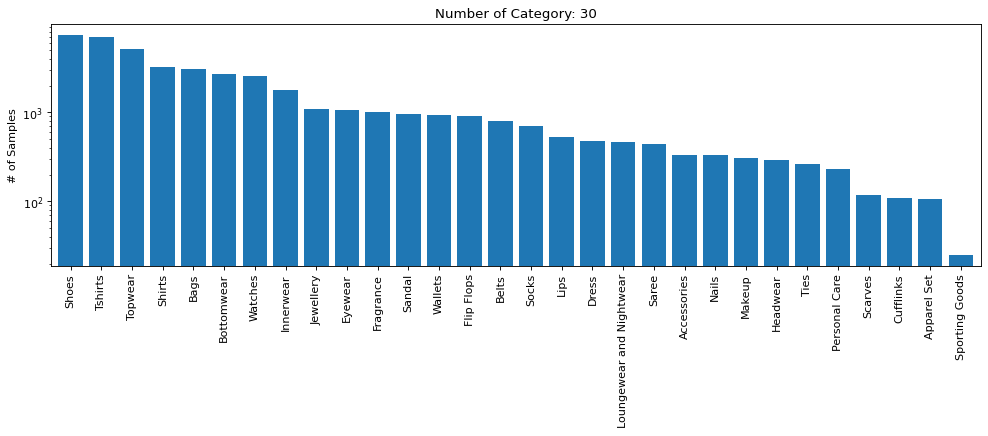

In [16]:
print('Number of classes:', styles_know.Class.value_counts().shape[0])

## See Categorical counts in `Class`
fig, ax = plt.subplots(figsize=(15, 4), dpi=80)
styles_know.Class.value_counts().plot.bar(ax=ax, align='center', width=0.8)
ax.set_yscale("log")
plt.ylabel('# of Samples')
plt.title('Number of Category: {}'.format(len(set(styles_know.Class))))
plt.show()

In [17]:
## LabelEncoder
# le = LabelEncoder()
# styles_know['Class_ind'] = le.fit_transform(styles_know['Class'])

import pickle

with open('gdrive/MyDrive/Tensorflow 2.0 Deep Learning and AI/valid_test_img.pickle', 'rb') as handle:
  image_valid_test = pickle.load(handle)
  # pickle.load(image_valid_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
image_valid_test.keys()

#image_valid_test['val_img']


dict_keys(['val_img', 'test_img'])

In [18]:
styles_know_train = styles_know[~(styles_know['image'].isin(image_valid_test['val_img']) | 
                                  styles_know['image'].isin(image_valid_test['val_img']))]
styles_know_valid = styles_know[styles_know['image'].isin(image_valid_test['val_img'])]
styles_know_test = styles_know[styles_know['image'].isin(image_valid_test['test_img'])]

print(styles_know_train.shape)
print(styles_know_valid.shape)
print(styles_know_test.shape)


(36421, 12)
(7993, 12)
(4445, 12)


## Train & Validation, and Test splits

Split `styles_know` into train-validation set (90%) and test set (10%).

In [19]:
samps_tot = len(styles_know)
rand_ind = np.random.permutation(np.arange(samps_tot))
print('Numebr of total samples:', samps_tot)

# Number of train (72%) & validation (18%) samples = 90%
num_of_tra_vid = samps_tot//10*9
print('Numebr of train (72%) and validation (18%):', num_of_tra_vid)

styles_know_train_valid = styles_know.iloc[rand_ind[:num_of_tra_vid]]
styles_know_test = styles_know.iloc[rand_ind[num_of_tra_vid:]]

print(styles_know_train_valid.shape)
print(styles_know_test.shape)


Numebr of total samples: 44414
Numebr of train (72%) and validation (18%): 39969
(39969, 12)
(4445, 12)


In [20]:
from keras_preprocessing.image import ImageDataGenerator

DATASET_PATH = 'myntradataset/images/' # Image folder
batch_size = 32 

# image_generator = ImageDataGenerator(
#     rescale=1./255,
#     validation_split=0.2,
#     horizontal_flip=True,  # Image augmentation with horizontal flipping.
#     #, width_shift_range=0.1, height_shift_range=0.1,
# )

# ## Train, validation splits
# train_generator = image_generator.flow_from_dataframe(
#     dataframe=styles_know_train_valid,
#     directory=DATASET_PATH,
#     x_col="image",
#     y_col="Class",
#     class_mode="categorical",
#     target_size=inputShape[:2],
#     batch_size=batch_size,
#     subset="training"#, color_mode="grayscale"
# )

# valid_generator = image_generator.flow_from_dataframe(
#     dataframe=styles_know_train_valid,
#     directory=DATASET_PATH,
#     x_col="image",
#     y_col="Class",
#     class_mode="categorical",
#     target_size=inputShape[:2],
#     batch_size=batch_size,
#     shuffle = False,
#     subset="validation"#,color_mode="grayscale"
# )


image_generator = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True, 
)

## Train, validation splits
train_generator = image_generator.flow_from_dataframe(
    dataframe=styles_know_train,
    directory=DATASET_PATH,
    x_col="image",
    y_col="Class",
    class_mode="categorical",
    target_size=inputShape[:2],
    batch_size=batch_size, #subset="training"#, 
    color_mode="grayscale"
)

valid_generator = image_generator.flow_from_dataframe(
    dataframe=styles_know_valid,
    directory=DATASET_PATH,
    x_col="image",
    y_col="Class",
    class_mode="categorical",
    target_size=inputShape[:2],
    batch_size=batch_size,
    shuffle = False, #subset="validation"#,
    color_mode="grayscale"
)




Found 36421 validated image filenames belonging to 30 classes.
Found 7993 validated image filenames belonging to 30 classes.


In [21]:
## Test sets
test_generator = image_generator.flow_from_dataframe(
    dataframe=styles_know_test,
    directory=DATASET_PATH,
    x_col="image",
    y_col="Class",
    class_mode="categorical",
    target_size=inputShape[:2],
    batch_size=1,
    shuffle = False,
    color_mode="grayscale"
    )

Found 4445 validated image filenames belonging to 30 classes.


number of classes: 30


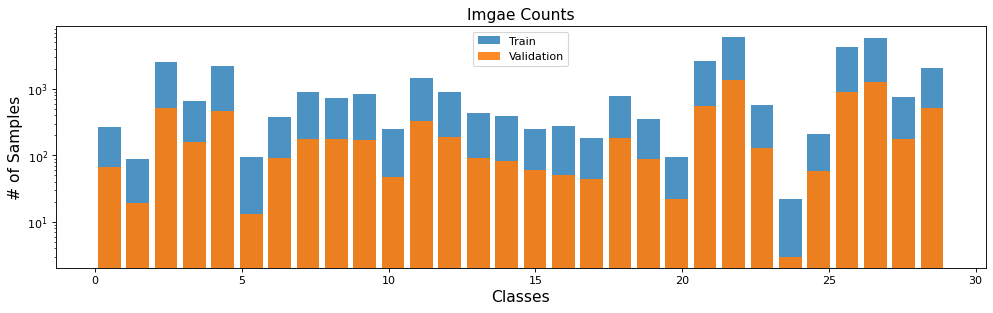

In [22]:
# Number of classes
classes = len(train_generator.class_indices) #len(set(styles_know['Class']))
print("number of classes:", classes)

# Images counts in each class
fig, ax = plt.subplots(figsize=(15, 4), dpi=80)
_ = plt.hist(train_generator.classes, bins=classes, alpha=0.8,
             histtype='bar', rwidth=0.8, label='Train')
_ = plt.hist(valid_generator.classes, bins=classes, alpha=0.9,
             histtype='bar', rwidth=0.8, label='Validation')

ax.set_yscale("log")
plt.xlabel('Classes', fontsize=14)
plt.ylabel('# of Samples', fontsize=14)
plt.title('Imgae Counts', fontsize=14)
plt.legend()
plt.show()

## Build the CNN classification model

In [23]:
## Build the model using the Keras API
chanDim = -1  # RGB Channel is last
model = tf.keras.models.Sequential()

# 1st CONV & RELU => BatchNorm => POOL layer set
model.add(Conv2D(32, (3, 3), activation='relu', padding='same',
                 input_shape=(80, 60, 1)))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 2nd CONV & RELU => BatchNorm => POOL layer set
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# first (and only) set of FC(fully connected) => RELU layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# softmax classifier
model.add(Dense(classes, activation='softmax'))

# initialize the optimizer and complie the model
NUM_EPOCHS = 8
INIT_LR = 1e-2

# Optimizers
#opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
#opt = tf.keras.optimizers.Adam(learning_rate=0.001)
opt = tf.keras.optimizers.SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)

model.compile(optimizer=opt,
              loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 60, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 60, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 60, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 60, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 30, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 30, 64)        1

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### (1) Training and Save the Best Model with Checkpoint

In [24]:
from keras.callbacks import ModelCheckpoint

## Callpoint settings. Save the model with the best validation accuracy.
filepath="model_best_gray.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

## Compile and fit
#STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
#STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

# Note: make sure to use GPU/TPU on Google Colab.
r=model.fit(x=train_generator,  #steps_per_epoch=STEP_SIZE_TRAIN,
            validation_data=valid_generator, #validation_steps=STEP_SIZE_VALID,
            callbacks=callbacks_list,
            epochs=NUM_EPOCHS)

Epoch 1/8
1139/1139 [==============================] - 1168s 1s/step - loss: 0.7552 - accuracy: 0.7790 - val_loss: 1.4183 - val_accuracy: 0.5958

Epoch 00001: val_accuracy improved from -inf to 0.59577, saving model to model_best_gray.h5
Epoch 2/8
1139/1139 [==============================] - 1164s 1s/step - loss: 0.4124 - accuracy: 0.8683 - val_loss: 15.3551 - val_accuracy: 0.5246

Epoch 00002: val_accuracy did not improve from 0.59577
Epoch 3/8
1139/1139 [==============================] - 1161s 1s/step - loss: 0.3297 - accuracy: 0.8936 - val_loss: 0.3387 - val_accuracy: 0.8932

Epoch 00003: val_accuracy improved from 0.59577 to 0.89316, saving model to model_best_gray.h5
Epoch 4/8
1139/1139 [==============================] - 1177s 1s/step - loss: 0.2823 - accuracy: 0.9080 - val_loss: 0.3182 - val_accuracy: 0.9013

Epoch 00004: val_accuracy improved from 0.89316 to 0.90129, saving model to model_best_gray.h5
Epoch 5/8
1139/1139 [==============================] - 1175s 1s/step - loss: 0

In [25]:
# model.fit(x_train, y_train, epochs=10, callbacks=callbacks_list, batch_size=32,
#           validation_data=(x_test, y_test))

#print('Batches train=%d, test=%d' % (len(train_iterator), len(valid_iterator)))

### (2) Check the Loss and Accuracy by Iterations

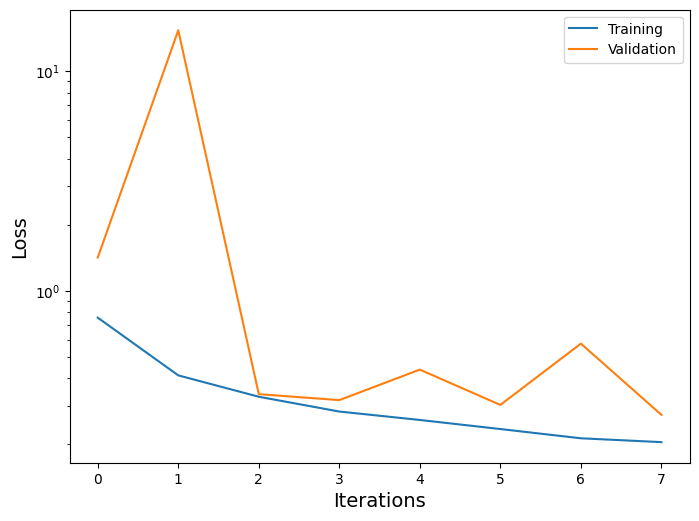

In [26]:
# Plot loss per iteration
#import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
plt.plot(r.history['loss'], label='Training')
plt.plot(r.history['val_loss'], label='Validation')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Loss', fontsize=14)
ax.set_yscale("log")
plt.legend()
plt.savefig('Loss_Iter.pdf', bbox_inches='tight')
plt.show()

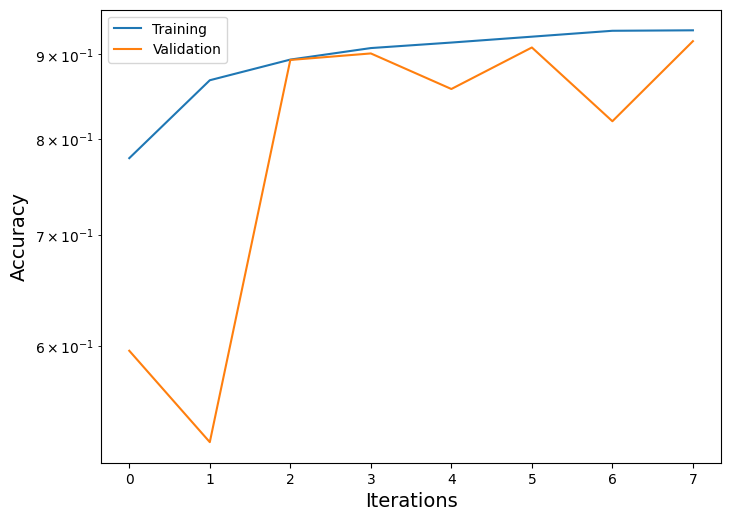

In [27]:
# Plot accuracy per iteration
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
plt.plot(r.history['accuracy'], label='Training')
plt.plot(r.history['val_accuracy'], label='Validation')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
ax.set_yscale("log")
plt.legend()
plt.savefig('Accu_Iter.pdf', bbox_inches='tight')
plt.show()

## Model Evaluation

### Load the Best Trained Model

In [28]:
## Save model
#model.save('my_model.h5')

# Load model
model_best = tf.keras.models.load_model('model_best_gray.h5')
# gdrive/MyDrive/Tensorflow 2.0 Deep Learning and AI/

# Check its architecture
model_best.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 60, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 60, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 60, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 60, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 30, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 30, 64)        1

In [29]:
# The accuracy for validation set
model_best.evaluate(valid_generator, batch_size=1)


250/250 [==============================] - 56s 224ms/step - loss: 0.2726 - accuracy: 0.9158


[0.272611141204834, 0.9158013463020325]

In [30]:
from sklearn.metrics import confusion_matrix, classification_report#, plot_confusion_matrix
import numpy as np
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  Code from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  #print(cm)

  plt.figure(figsize=(24, 20))
  ax = plt.gca()
  sns.heatmap(cm, annot=True, fmt="d", linewidths=.01, cmap=cmap, #"YlGnBu", 
            xticklabels=classes,
            yticklabels=classes,
            ax=ax)
  
  ax.set_title(title)
  ax.set_ylabel('True label')
  ax.set_xlabel('Predicted label')
  plt.tight_layout()
  
  # cax = divider.append_axes("right", size="5%", pad=0.05)
  # plt.colorbar(im, cax=cax)
  plt.show()

In [31]:
#labels = {v: k for k, v in train_generator.class_indices.items()}
labels = {v: k for k, v in valid_generator.class_indices.items()}
labels

{0: 'Accessories',
 1: 'Apparel Set',
 2: 'Bags',
 3: 'Belts',
 4: 'Bottomwear',
 5: 'Cufflinks',
 6: 'Dress',
 7: 'Eyewear',
 8: 'Flip Flops',
 9: 'Fragrance',
 10: 'Headwear',
 11: 'Innerwear',
 12: 'Jewellery',
 13: 'Lips',
 14: 'Loungewear and Nightwear',
 15: 'Makeup',
 16: 'Nails',
 17: 'Personal Care',
 18: 'Sandal',
 19: 'Saree',
 20: 'Scarves',
 21: 'Shirts',
 22: 'Shoes',
 23: 'Socks',
 24: 'Sporting Goods',
 25: 'Ties',
 26: 'Topwear',
 27: 'Tshirts',
 28: 'Wallets',
 29: 'Watches'}

### (1) Evaluation on Training set

In [91]:
# The accuracy for training set
model_best.evaluate(train_generator, batch_size=1)

1139/1139 [==============================] - 253s 222ms/step - loss: 0.1615 - accuracy: 0.9458


[0.16151432693004608, 0.9458004832267761]

In [92]:
train_generator = image_generator.flow_from_dataframe(
    dataframe=styles_know_train,
    directory=DATASET_PATH,
    x_col="image",
    y_col="Class",
    class_mode="categorical",
    target_size=inputShape[:2],
    batch_size=batch_size, #subset="training"#, 
    shuffle=False,
    color_mode="grayscale"
)

Found 36421 validated image filenames belonging to 30 classes.


In [93]:
# The accuracy for validation set
model_best.evaluate(train_generator, batch_size=1)


1139/1139 [==============================] - 251s 220ms/step - loss: 0.1598 - accuracy: 0.9474


[0.159759521484375, 0.9474204182624817]

In [105]:
# Prediction on training set
p_train = model_best.predict(train_generator).argmax(axis=1)

# True labels of training set
y_train = list(train_generator.classes)
len(y_train)

36421

In [106]:
x, _ = zip(*(train_generator[i] for i in range(len(train_generator))))
x_train = np.vstack(x)

Confusion matrix, without normalization


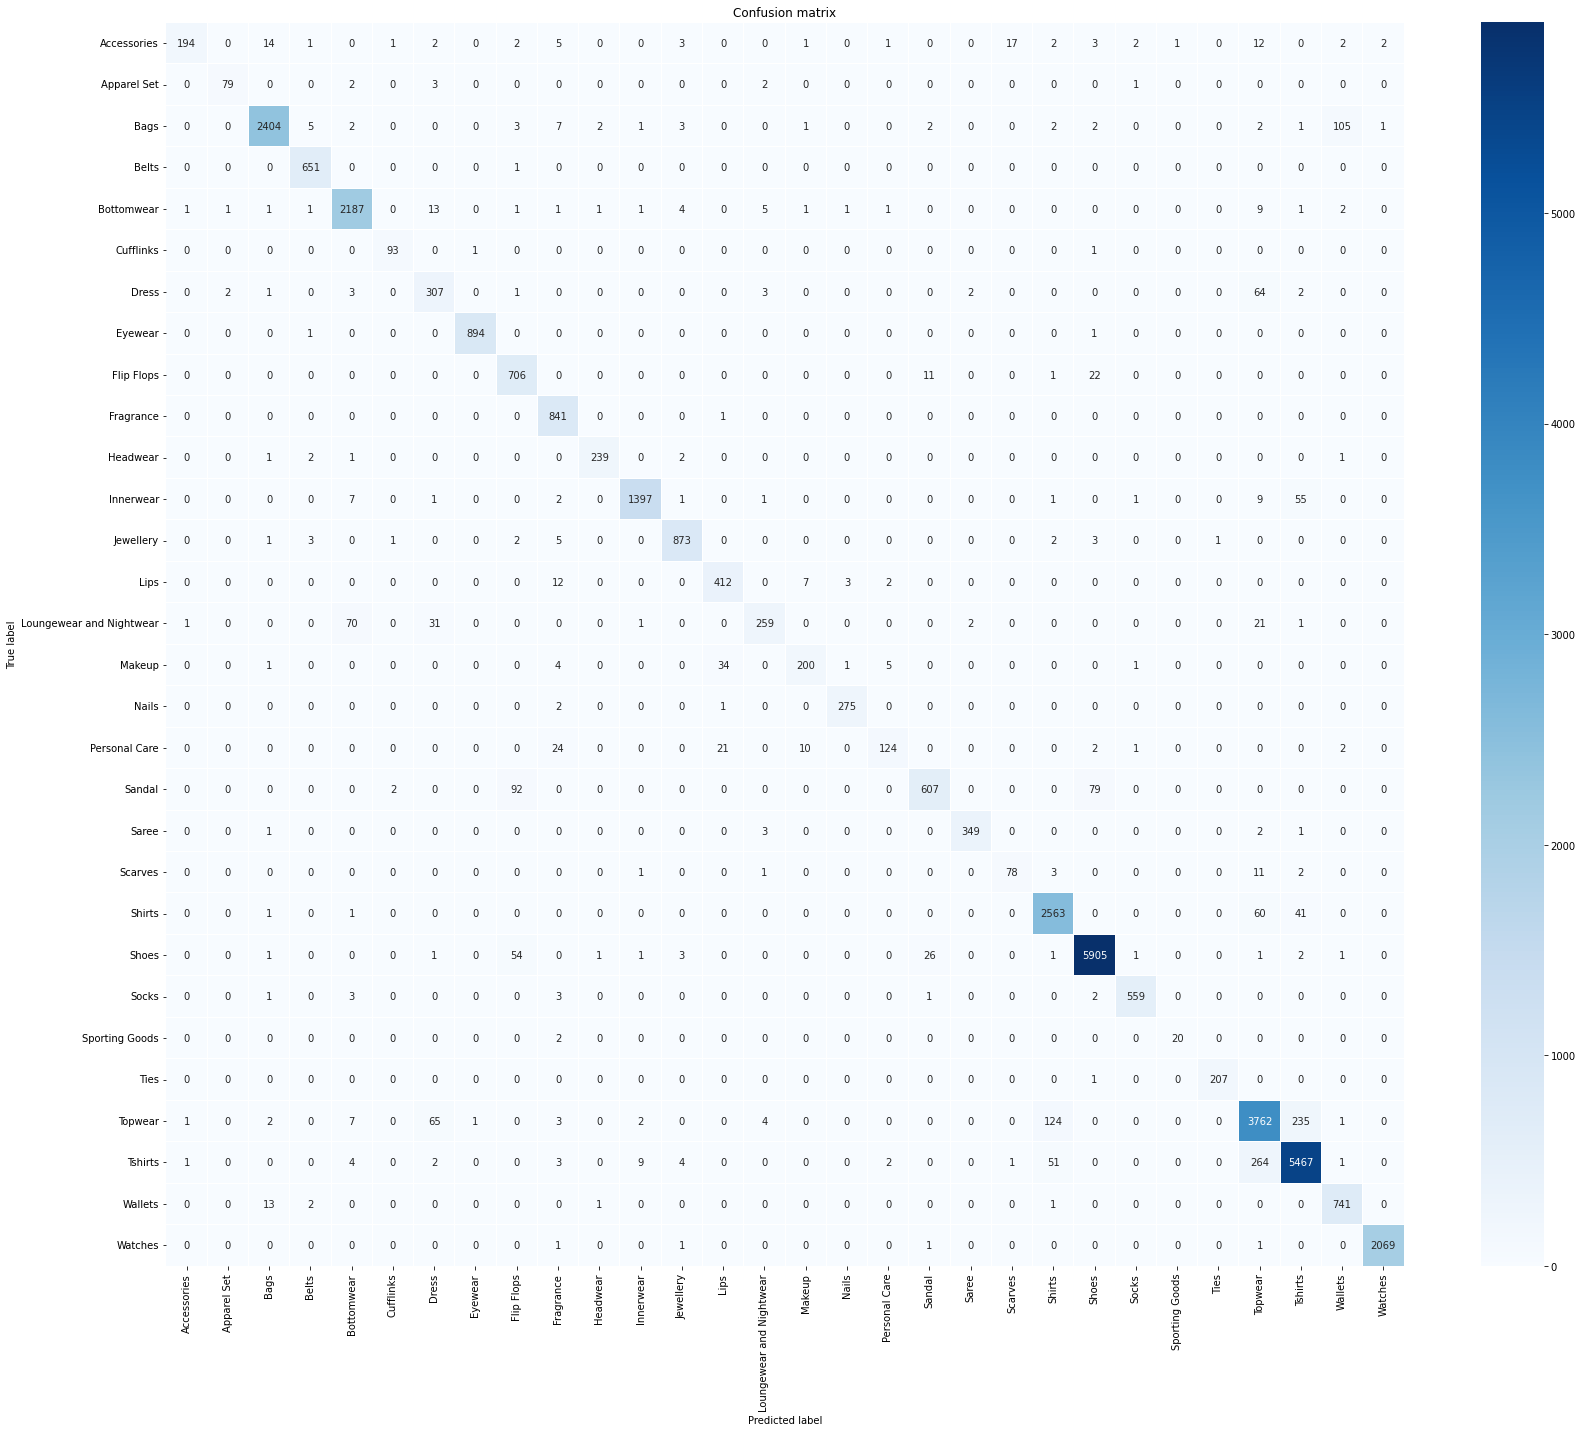

              precision    recall  f1-score   support

           0       0.98      0.73      0.84       265
           1       0.96      0.91      0.93        87
           2       0.98      0.95      0.96      2543
           3       0.98      1.00      0.99       652
           4       0.96      0.98      0.97      2232
           5       0.96      0.98      0.97        95
           6       0.72      0.80      0.76       385
           7       1.00      1.00      1.00       896
           8       0.82      0.95      0.88       740
           9       0.92      1.00      0.96       842
          10       0.98      0.97      0.98       246
          11       0.99      0.95      0.97      1475
          12       0.98      0.98      0.98       891
          13       0.88      0.94      0.91       436
          14       0.93      0.67      0.78       386
          15       0.91      0.81      0.86       246
          16       0.98      0.99      0.99       278
          17       0.92    

30

In [107]:
class_name = [labels[i] for i in list(set(train_generator.classes))]

cm = tf.math.confusion_matrix(y_train, p_train).numpy() 
plot_confusion_matrix(cm, class_name)

print(classification_report(y_train, p_train))
clsf_report = pd.DataFrame(classification_report(y_train, p_train, output_dict=True)).transpose()
clsf_report.to_csv('ClassiReport_Train.csv', index=True)
len(class_name)

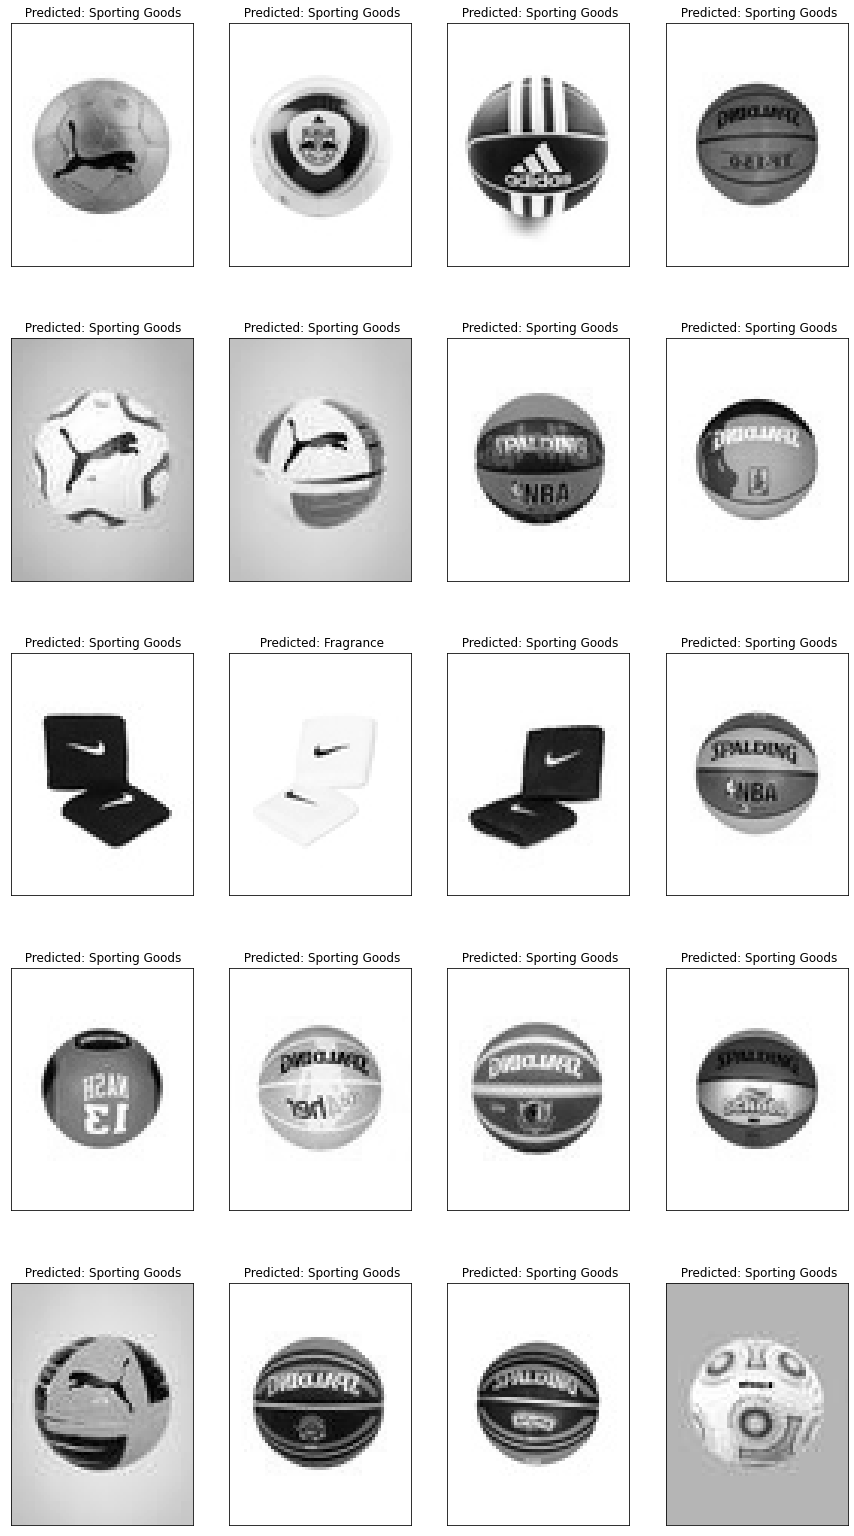

In [113]:

misclassified_idx = np.where(np.array(y_train) == 24)[0]
misclassified_idx
fig, axes = plt.subplots(5, 4, figsize=(15, 28))
for i, img in enumerate(misclassified_idx[:20]):
  ax = axes.flat[i]
  #ax.imshow(x_test[img])
  ax.imshow(np.squeeze(x_train[img], -1), cmap='gray')
  # ax.set_title("True: %s  Predicted: %s" % 
  #           (labels[y_train[img]], labels[p_train[img]]));
  ax.set_title(" Predicted: %s" % 
            (labels[p_train[img]]));
  ax.axes.xaxis.set_visible(False)
  ax.axes.yaxis.set_visible(False)

plt.show()

### (2) Evaluation on Validation set

In [ ]:
# The accuracy for validation set
model_best.evaluate(valid_generator, batch_size=1)


In [66]:
# Prediction on validation set
p_test = model_best.predict(valid_generator).argmax(axis=1)

# True labels of validation set
y_test = list(valid_generator.classes)
len(y_test)

7993

In [67]:
# Collect the test images: x_test
x, _ = zip(*(valid_generator[i] for i in range(len(valid_generator))))
x_test = np.vstack(x)
x_test.shape
# x, y_train = zip(*(train_generator[i] for i in range(len(train_generator))))
# x_train = np.vstack(x)
# y_train = np.vstack(y_train).argmax(axis=1).tolist()

(7993, 80, 60, 1)

In [68]:
import pickle

# ## Save the train test set
# image_train_valid = {'x_train': x_train, 'y_train': y_train, 'x_test': x_test, 'y_test': y_test}

# with open('train_test_img.pickle', 'wb') as handle:
#     pickle.dump(image_train_valid, handle, protocol=pickle.HIGHEST_PROTOCOL)
# image_train_valid.keys()

######
## Save the image name for validation and test set
# val_img = valid_generator.filenames
# test_img = test_generator.filenames
# image_valid_test = {'val_img': val_img, 'test_img': test_img}

# with open('valid_test_img.pickle', 'wb') as handle:
#   pickle.dump(image_valid_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
# image_valid_test.keys()


Confusion matrix, without normalization


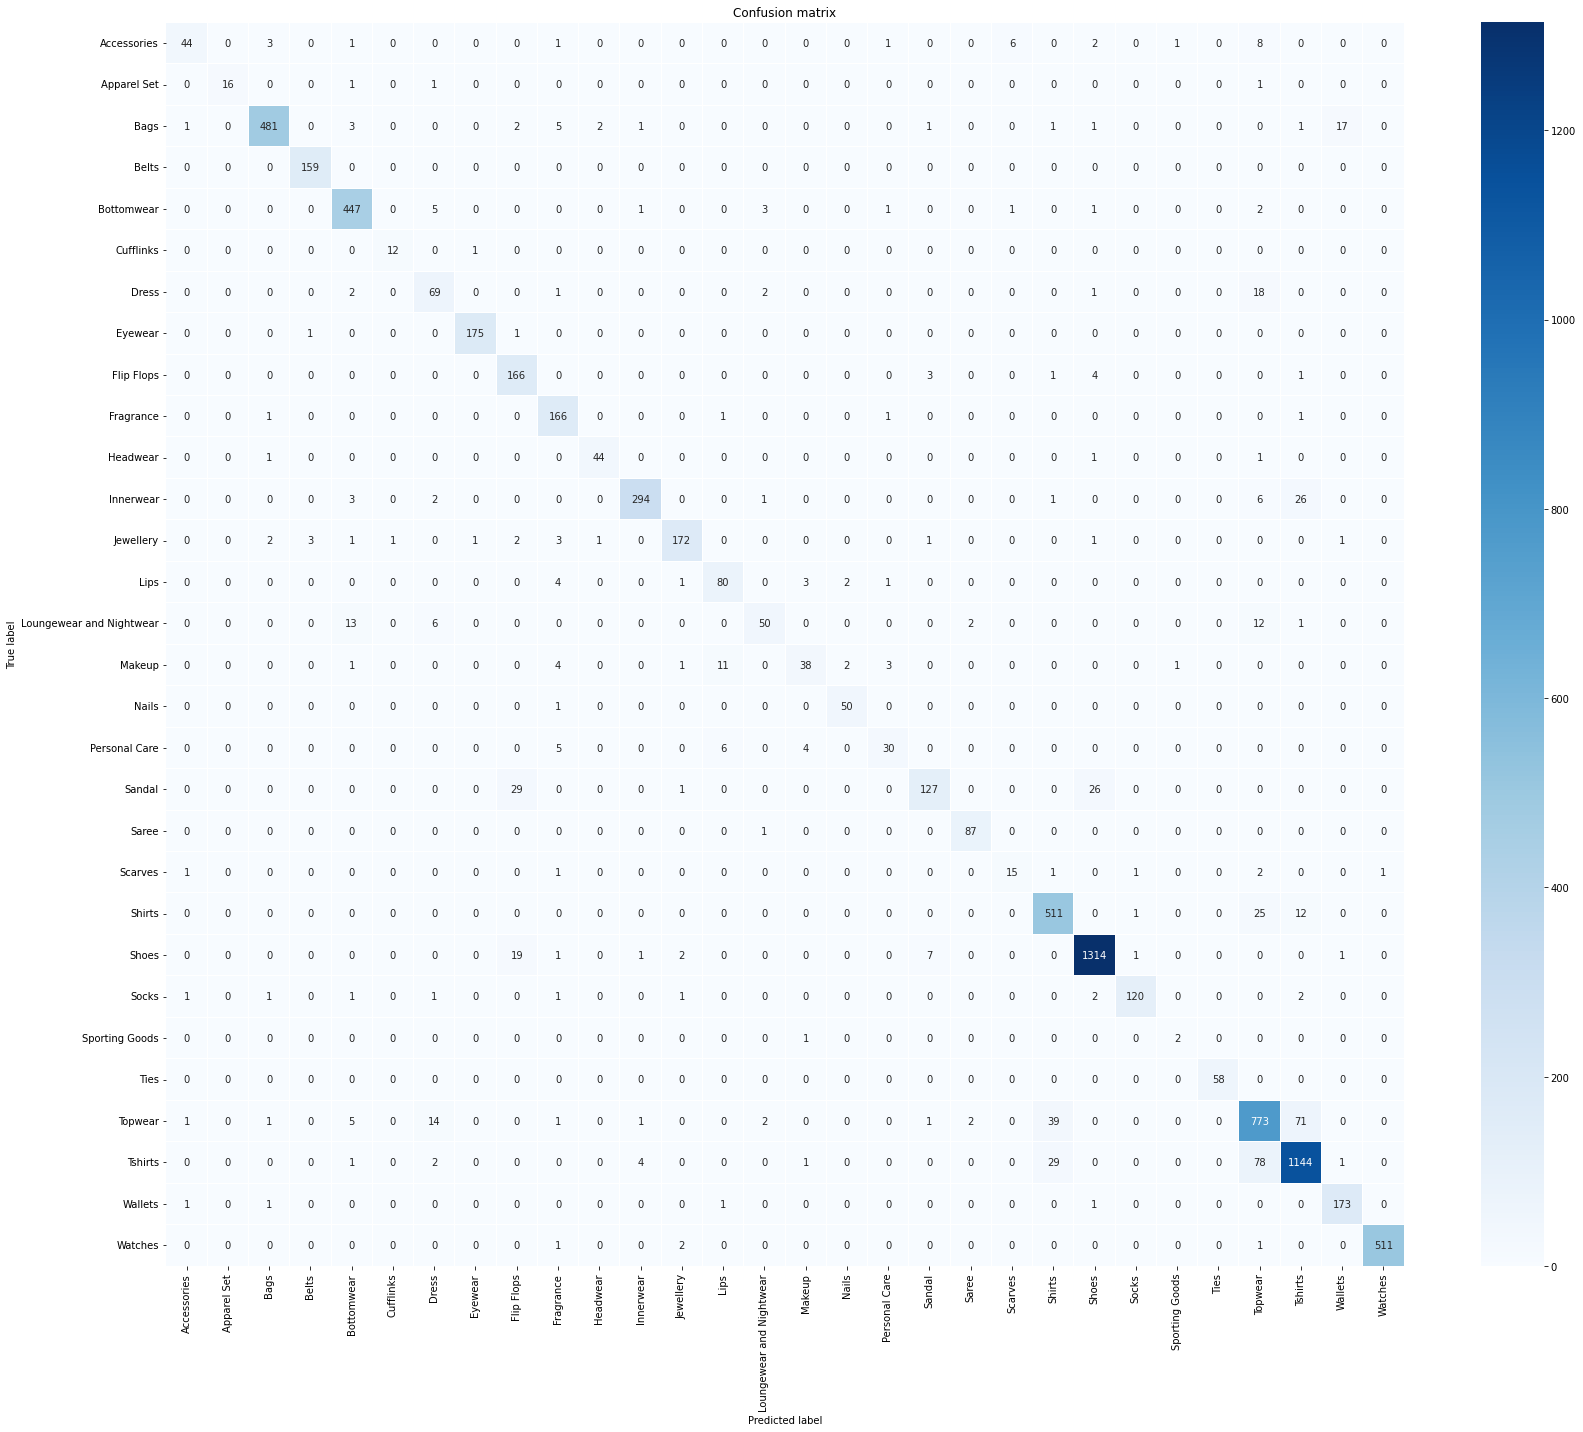

              precision    recall  f1-score   support

           0       0.90      0.66      0.76        67
           1       1.00      0.84      0.91        19
           2       0.98      0.93      0.96       516
           3       0.98      1.00      0.99       159
           4       0.93      0.97      0.95       461
           5       0.92      0.92      0.92        13
           6       0.69      0.74      0.72        93
           7       0.99      0.99      0.99       177
           8       0.76      0.95      0.84       175
           9       0.85      0.98      0.91       170
          10       0.94      0.94      0.94        47
          11       0.97      0.88      0.93       333
          12       0.96      0.91      0.93       189
          13       0.81      0.88      0.84        91
          14       0.85      0.60      0.70        84
          15       0.81      0.62      0.70        61
          16       0.93      0.98      0.95        51
          17       0.81    

30

In [69]:
# Plot confusion matrix
#labels = {v: k for k, v in valid_generator.class_indices.items()}
class_name = [labels[i] for i in list(set(valid_generator.classes))]

cm = tf.math.confusion_matrix(y_test, p_test).numpy() 
#cm=confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, class_name)

print(classification_report(y_test, p_test))
clsf_report = pd.DataFrame(classification_report(y_test, p_test, output_dict=True)).transpose()
clsf_report.to_csv('ClassiReport_Valid.csv', index=True)
len(class_name)

In [70]:
# Label comparison
print('Number of misclassified images:', np.sum(p_test != y_test))
print('Percentage of misclassified images: %.3f' % (np.mean(p_test != y_test)))

Number of misclassified images: 665
Percentage of misclassified images: 0.083


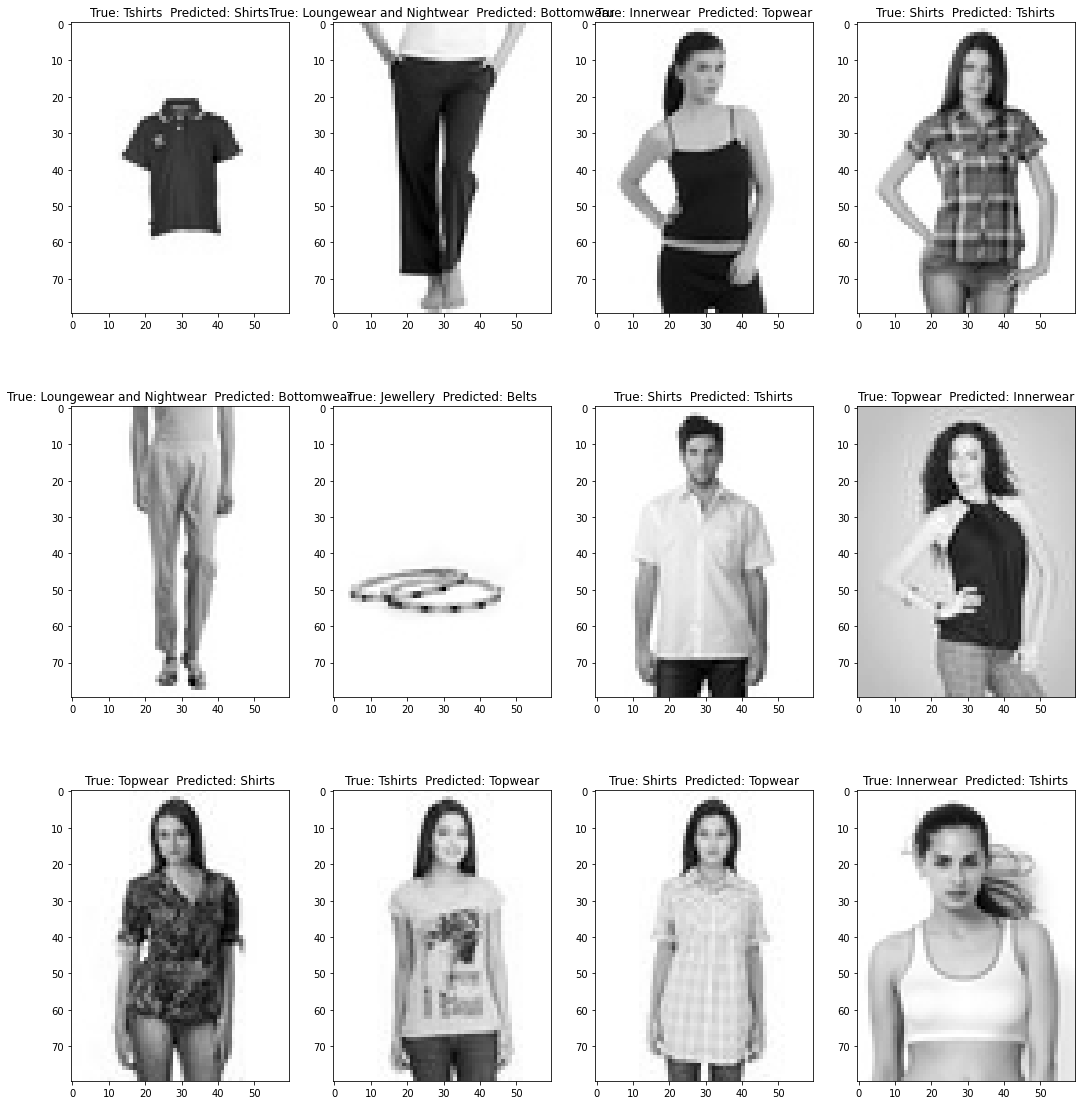

In [71]:
# Show some misclassified examples
misclassified_idx = np.where(p_test != y_test)[0]

fig, axes = plt.subplots(3, 4, figsize=(18, 20))
for i, img in enumerate(np.random.choice(misclassified_idx, 12)):
  ax = axes.flat[i]
  #ax.imshow(x_test[img])
  ax.imshow(np.squeeze(x_test[img], -1), cmap='gray')
  ax.set_title("True: %s  Predicted: %s" % 
            (labels[y_test[img]], labels[p_test[img]]));
plt.show()

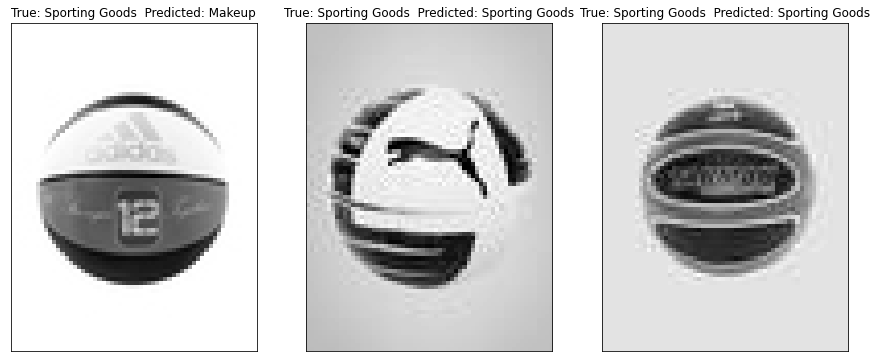

In [89]:
# Show some misclassified #20

misclassified_idx = np.where(np.array(y_test) == 24)[0]

fig, axes = plt.subplots(1, 3, figsize=(15, 28))
for i, img in enumerate(misclassified_idx):
  ax = axes.flat[i]
  #ax.imshow(x_test[img])
  ax.imshow(np.squeeze(x_test[img], -1), cmap='gray')
  ax.set_title("True: %s  Predicted: %s" % 
            (labels[y_test[img]], labels[p_test[img]]));
  ax.axes.xaxis.set_visible(False)
  ax.axes.yaxis.set_visible(False)

plt.show()

### (3) Evaluation on Hold-on (test) set

In [55]:
# The accuracy for test set
model_best.evaluate(test_generator, batch_size=1)


4445/4445 [==============================] - 72s 16ms/step - loss: 0.1870 - accuracy: 0.9417


[0.1870235949754715, 0.9417322874069214]

In [63]:
# Prediction on hold-on set
p_test = model_best.predict(test_generator).argmax(axis=1)

# True labels of hold-on set
y_test = list(test_generator.classes)
len(y_test)

4445

In [64]:
# Collect the test images: x_test
x, _ = zip(*(test_generator[i] for i in range(len(test_generator))))
x_test = np.vstack(x)

Confusion matrix, without normalization


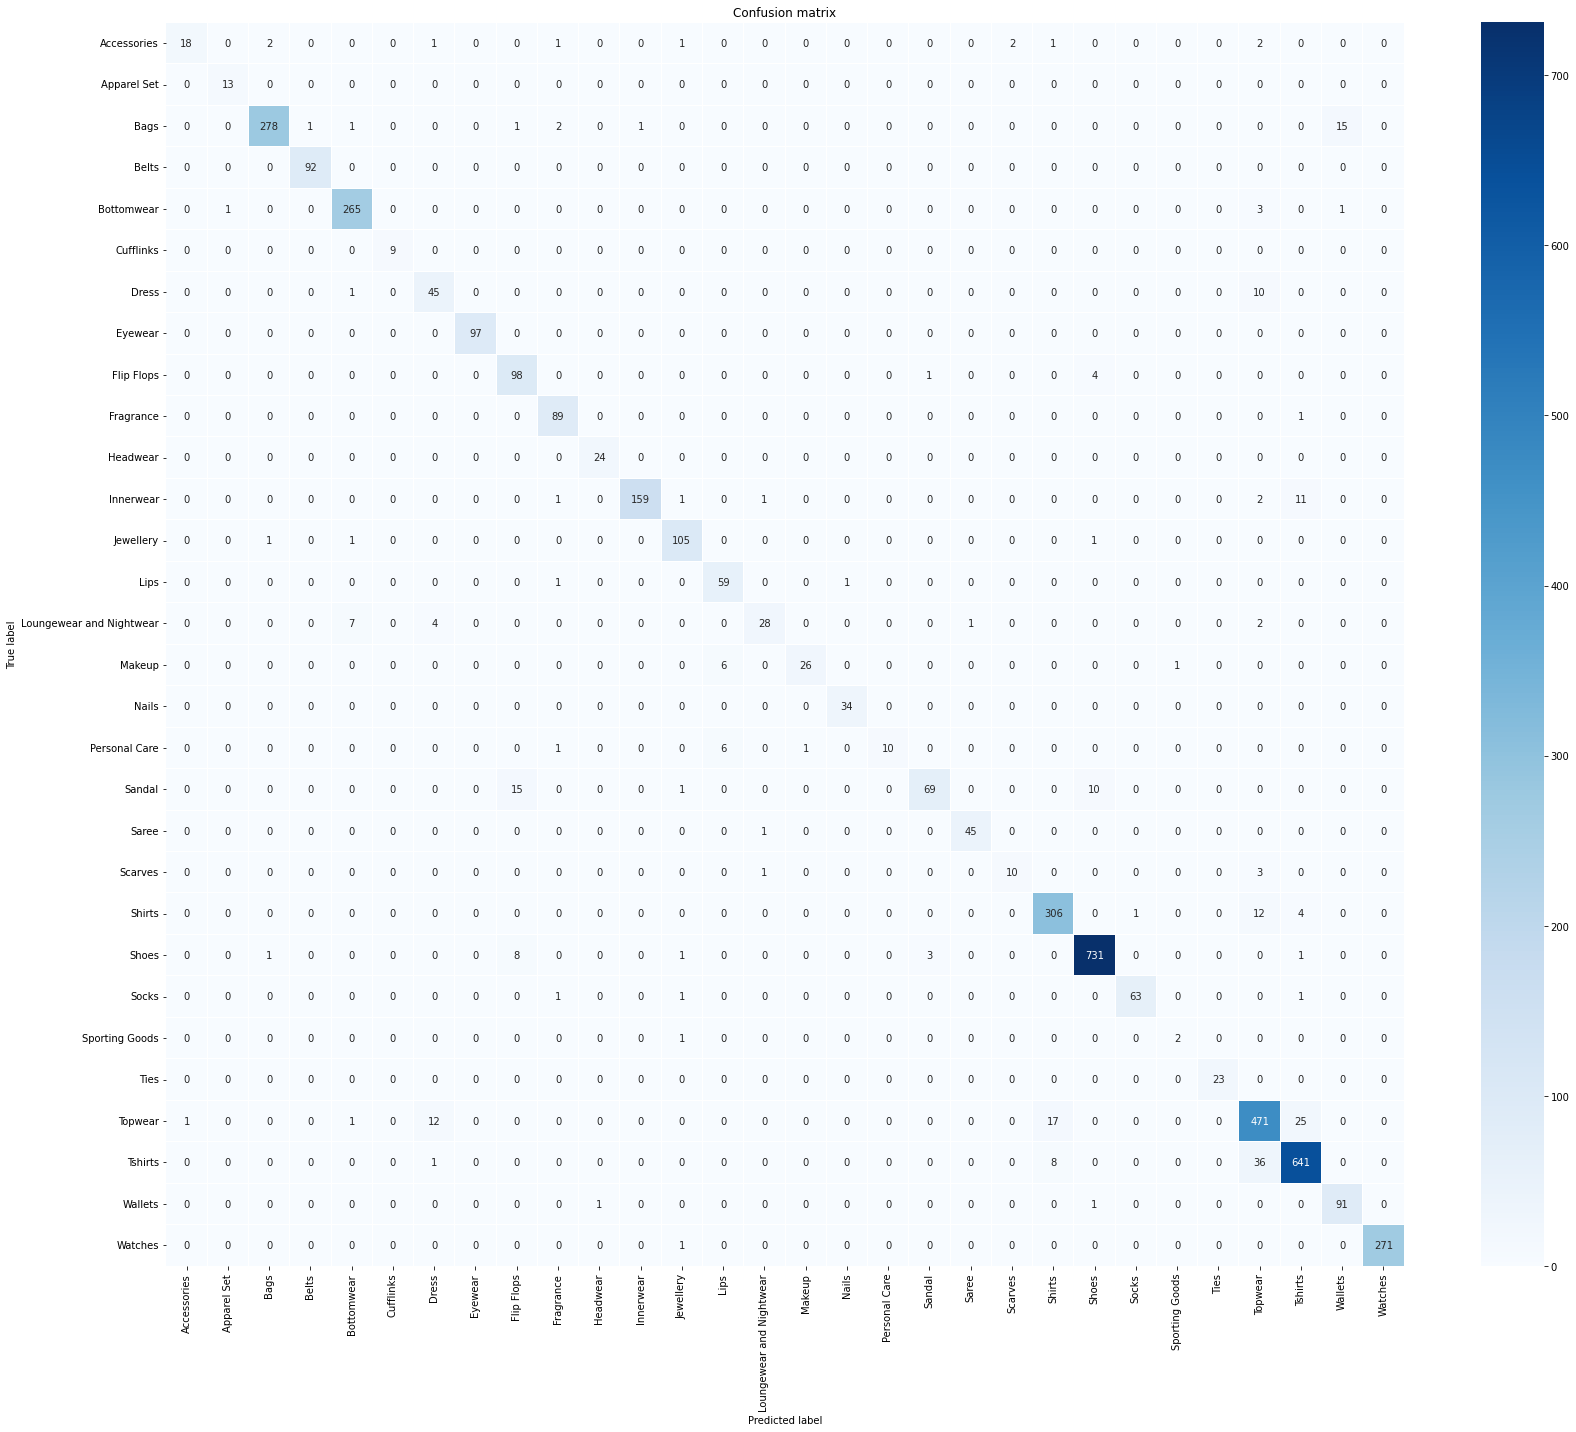

              precision    recall  f1-score   support

           0       0.95      0.64      0.77        28
           1       0.93      1.00      0.96        13
           2       0.99      0.93      0.96       299
           3       0.99      1.00      0.99        92
           4       0.96      0.98      0.97       270
           5       1.00      1.00      1.00         9
           6       0.71      0.80      0.76        56
           7       1.00      1.00      1.00        97
           8       0.80      0.95      0.87       103
           9       0.93      0.99      0.96        90
          10       0.96      1.00      0.98        24
          11       0.99      0.91      0.95       175
          12       0.94      0.97      0.95       108
          13       0.83      0.97      0.89        61
          14       0.90      0.67      0.77        42
          15       0.96      0.79      0.87        33
          16       0.97      1.00      0.99        34
          17       1.00    

In [65]:
# Plot confusion matrix
class_name = [labels[i] for i in list(set(test_generator.classes))]
#labels = {v: k for k, v in test_generator.class_indices.items()}
cm = tf.math.confusion_matrix(y_test, p_test).numpy() #confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, class_name)
print(classification_report(y_test, p_test))
clsf_report = pd.DataFrame(classification_report(y_test, p_test, output_dict=True)).transpose()
clsf_report.to_csv('ClassiReport_hold.csv', index=True)


In [62]:
# Percentage of misclassified
print('Percentage of misclassified images: %.3f' % (np.mean(p_test != y_test)))

Percentage of misclassified images: 0.059


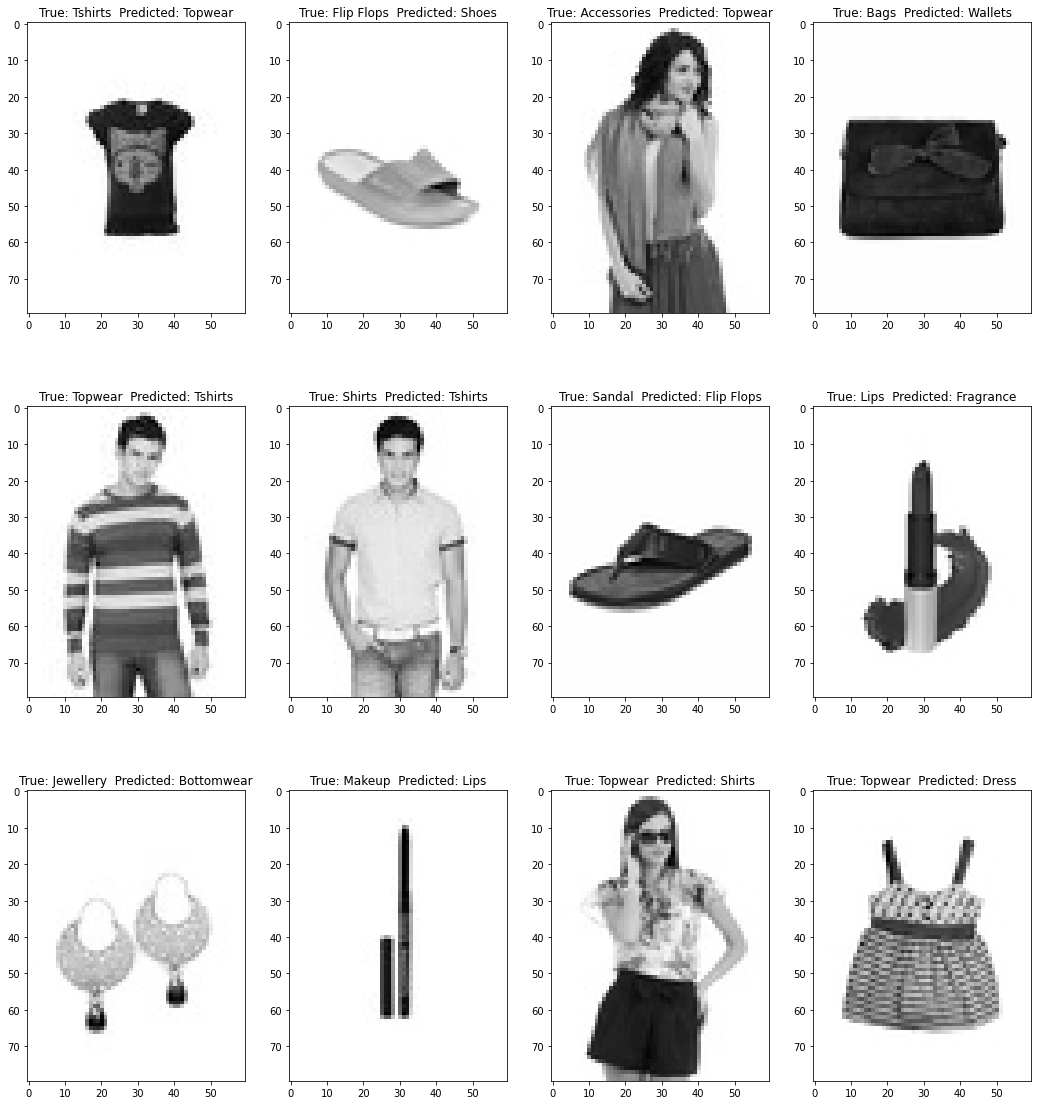

In [50]:
# Show some misclassified examples
misclassified_idx = np.where(p_test != y_test)[0]

fig, axes = plt.subplots(3, 4, figsize=(18, 20))
for i, img in enumerate(np.random.choice(misclassified_idx, 12)):
  ax = axes.flat[i]
  #ax.imshow(x_test[img])
  ax.imshow(np.squeeze(x_test[img], -1), cmap='gray')
  ax.set_title("True: %s  Predicted: %s" % 
            (labels[y_test[img]], labels[p_test[img]]));
plt.show()

## Prediect the Classes for Mislabeled Images

We are going to predict the classes for images lebeled as `Free Items`, listed in the DataFrame `styles_unkonw`. These images are new (not in train and validation sets). As we shell see, for most of the cases the predicted labels match the images.

In [90]:
print(styles_unkonw.shape)
styles_unkonw.head()

(26, 12)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,Class,image
2663,54970,Women,Free Items,Free Gifts,Free Gifts,Pink,Spring,2017,Casual,Rasasi Women Body Lotion,Unknow,54970.jpg
2871,15349,Men,Free Items,Free Gifts,Free Gifts,Blue,Winter,2012,Sports,Nike Men Blue Team India Cricket Jersey,Unknow,15349.jpg
5812,50234,Women,Free Items,Free Gifts,Free Gifts,White,Summer,2017,Casual,Stoln Women White Sunglasses,Unknow,50234.jpg
6815,43285,Women,Free Items,Free Gifts,Backpacks,Black,Summer,2016,Casual,Murcia Women Black Backpack,Unknow,43285.jpg
7923,15658,Unisex,Free Items,Free Gifts,Free Gifts,Blue,Winter,2016,Casual,Belkin Unisex Simple Messenger Blue Handbags,Unknow,15658.jpg


In [52]:
new_generator = image_generator.flow_from_dataframe(
    dataframe=styles_unkonw,
    directory=DATASET_PATH,
    x_col="image",
    y_col="Class",
    class_mode="categorical",
    target_size=inputShape[:2],
    batch_size=1,
    shuffle = False,
    color_mode="grayscale"
    )

Found 26 validated image filenames belonging to 1 classes.


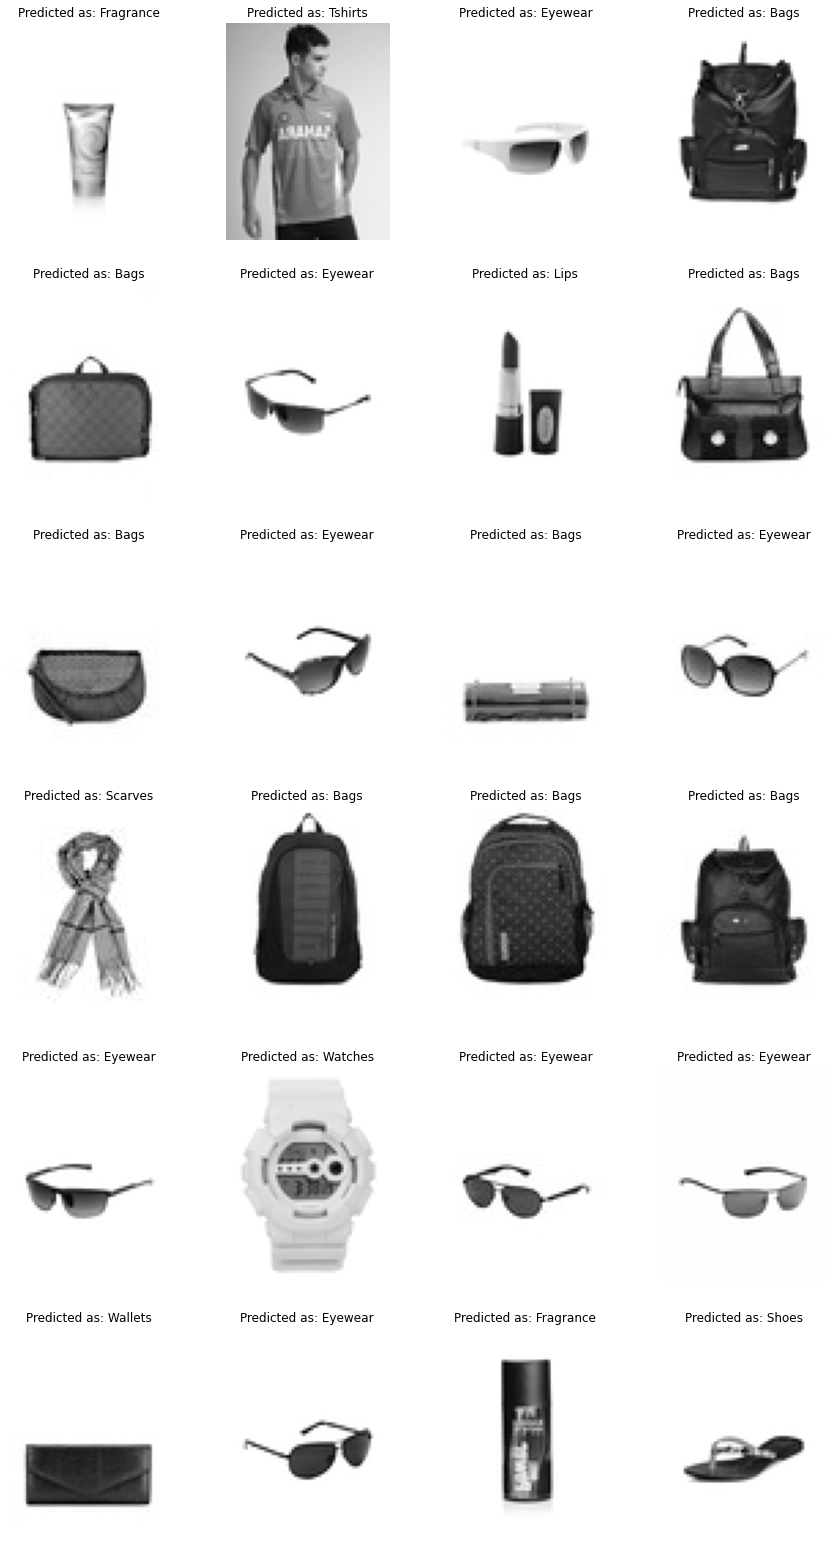

In [114]:
# Predicted labels
p_new = model_best.predict(new_generator).argmax(axis=1)

# Show some new examples
fig, axes = plt.subplots(6, 4, figsize=(15, 28))

for i in range(24):
  # New images
  x_new = new_generator[i][0][0]
  
  ax = axes.flat[i]
  ax.imshow(np.squeeze(x_new, -1), cmap='gray')
  #ax.imshow(x_new)
  ax.axis('off')
  ax.set_title("Predicted as: %s" % (labels[p_new[i]]))

plt.show()